# Flatiron Data Science - Project 2
## Building a Linear Regression Model<br>Kings County Housing Prices Bakeoff

Khyatee Desai<br>October 23, 2020

# Step 1: Read in Data

In [140]:
import pandas as pd
import numpy as np
from geopy import distance
from geopy import Point
from itertools import combinations
import matplotlib.pyplot as plt
import statistics as stats
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [84]:
# read in training dataset
df = pd.read_csv('kc_house_data_train.csv')

# Step 2: Data Cleaning & Outliers

In [85]:
df.isnull().sum().any()

False

In [86]:
df.dtypes

Unnamed: 0         int64
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

### Change date strings to datetime

In [87]:
df['yr_sold'] = pd.to_datetime(df['date'].str.slice(0,8), format='%Y%m%d', errors='ignore').dt.year
df.drop('date',axis=1,inplace=True)

### Drop first two columns because the aren't relevant

In [88]:
df.drop(columns=['Unnamed: 0', 'id'],axis=1,inplace=True)
df.sort_values('price', ascending=False).head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold
10366,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800,2014
6903,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449,2014
7519,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730,2014
2232,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345,2014
1979,5350000.0,5,5.00,8000,23985,2.0,0,4,3,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750,2015
5039,5300000.0,6,6.00,7390,24829,2.0,1,4,4,12,5000,2390,1991,0,98040,47.5631,-122.210,4320,24619,2015
14668,5110800.0,5,5.25,8010,45517,2.0,1,4,3,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788,2014
15816,4668000.0,5,6.75,9640,13068,1.0,1,4,3,12,4820,4820,1983,2009,98040,47.5570,-122.210,3270,10454,2014
4177,4500000.0,5,5.50,6640,40014,2.0,1,4,3,12,6350,290,2004,0,98155,47.7493,-122.280,3030,23408,2014
14477,4489000.0,4,3.00,6430,27517,2.0,0,0,3,12,6430,0,2001,0,98004,47.6208,-122.219,3720,14592,2014


### Impute Outliers

In [89]:
for feat in ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',  'sqft_above', 'sqft_basement','sqft_living15', 'sqft_lot15']: 
    above_6std = df[feat].mean()+(6*df[feat].std())
    # if outliers are above 6 standard devs, reduce to 6 standard devs from mean
    df[feat] = np.where(df[feat].values >above_6std, df[feat].mean()+6*df[feat].std(), df[feat])
df.sort_values('price', ascending=False).head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold
10366,7700000.0,6.0,6.734801,7601.57584,27600.0,2.5,0,3,4,13,6764.896657,2951.069836,1910,1987,98102,47.6298,-122.323,3940.0,8800.0,2014
6903,7062500.0,5.0,4.500000,7601.57584,37325.0,2.0,1,2,3,11,6764.896657,2360.000000,1940,2001,98004,47.6500,-122.214,3930.0,25449.0,2014
7519,6885000.0,6.0,6.734801,7601.57584,31374.0,2.0,0,4,3,13,6764.896657,1030.000000,2001,0,98039,47.6305,-122.240,4540.0,42730.0,2014
2232,5570000.0,5.0,5.750000,7601.57584,35069.0,2.0,0,0,3,13,6200.000000,2951.069836,2001,0,98039,47.6289,-122.233,3560.0,24345.0,2014
1979,5350000.0,5.0,5.000000,7601.57584,23985.0,2.0,0,4,3,12,6720.000000,1280.000000,2009,0,98004,47.6232,-122.220,4600.0,21750.0,2015
5039,5300000.0,6.0,6.000000,7390.00000,24829.0,2.0,1,4,4,12,5000.000000,2390.000000,1991,0,98040,47.5631,-122.210,4320.0,24619.0,2015
14668,5110800.0,5.0,5.250000,7601.57584,45517.0,2.0,1,4,3,12,5990.000000,2020.000000,1999,0,98033,47.6767,-122.211,3430.0,26788.0,2014
15816,4668000.0,5.0,6.734801,7601.57584,13068.0,1.0,1,4,3,12,4820.000000,2951.069836,1983,2009,98040,47.5570,-122.210,3270.0,10454.0,2014
4177,4500000.0,5.0,5.500000,6640.00000,40014.0,2.0,1,4,3,12,6350.000000,290.000000,2004,0,98155,47.7493,-122.280,3030.0,23408.0,2014
14477,4489000.0,4.0,3.000000,6430.00000,27517.0,2.0,0,0,3,12,6430.000000,0.000000,2001,0,98004,47.6208,-122.219,3720.0,14592.0,2014


### Check Baseline Regression R-squared Value

In [90]:
y = df[['price']]
X = df.iloc[:,1:]
baseline = LinearRegression()
baseline.fit(X,y)
baseline.score(X,y)

0.7078872456719291

# Step 3: Exploratory Data Analysis 
    
Become familiar with the data.  Look to see if there are any extreme values.  
Additionally create data visualizations to determine if there are any relationships between your features and your target variables.  

- **Exploratory Data Analysis (EDA)**: You must create at least 4 data visualizations that help to explain the data. These visualizations should help someone unfamiliar with the data understand the target variable and the features that help explain that target variable.
- **Statistical Tests**: Your notebook must show at least 3 statistical tests that you preformed on your data set. Think of these as being part of your EDA process; for example, if you think houses with a view cost more than those without a view, then perform a two-sample T-test. These can be preliminary evidence that a feature will be important in your model.


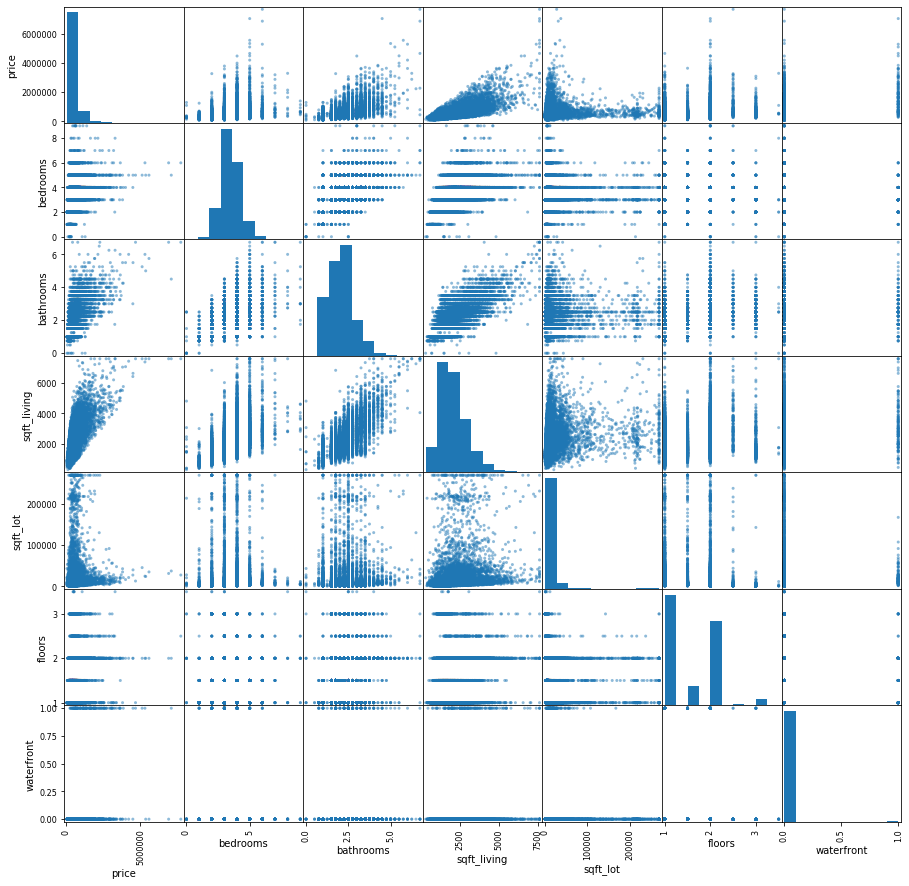

In [91]:
pd.plotting.scatter_matrix(df.iloc[:,:7], figsize= [15,15]);

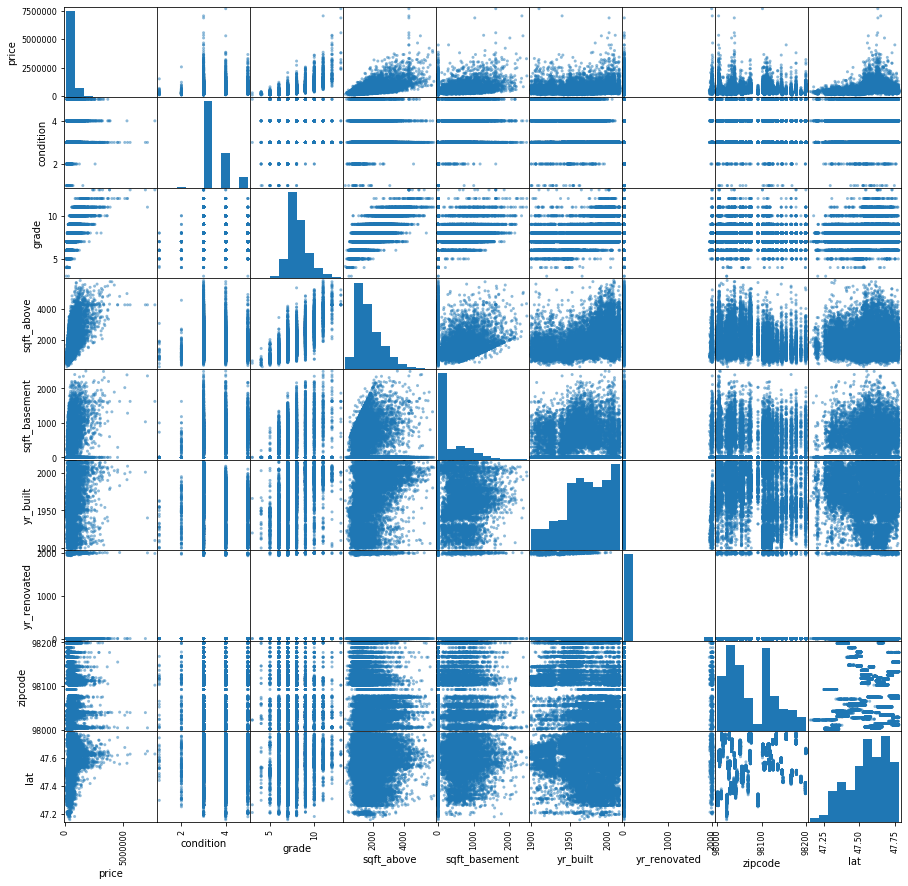

In [11]:
df2 = pd.concat([df['price'],df.iloc[:,7:14]], axis=1)
pd.plotting.scatter_matrix(df2, figsize= [15,15]);

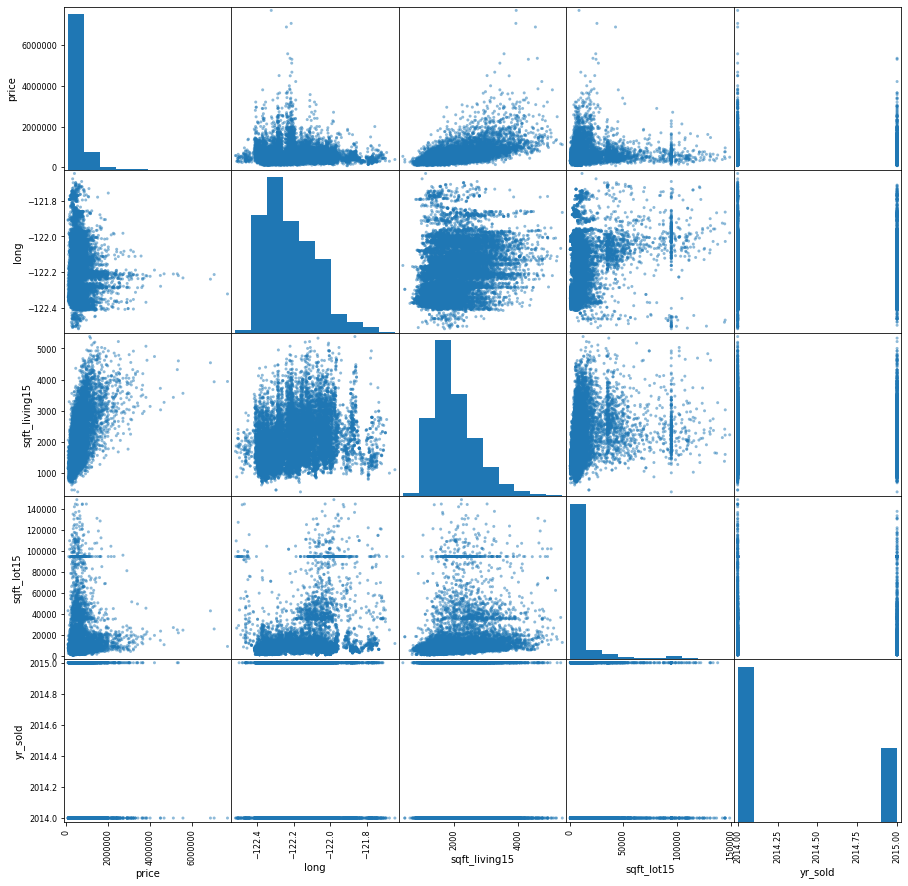

In [12]:
df3 = pd.concat([df['price'],df.iloc[:,14:]], axis=1)
pd.plotting.scatter_matrix(df3, figsize= [15,15]);

## Stats Test 1: Waterfront vs. Price
### 2-sample one-tail Welch's T-Test (significance level: 0.05) 
**Rationale:** Comparing the means of two independent samples<br>
**Ho:** Houses on a waterfront sell for the same amount on average as houses not on a waterfront.<br>
**Ha:** Houses on a waterfront sell for more on average than houses not on a waterfront.

In [92]:
# create the samples from main dataframe
waterfront = df[df['waterfront']==1]
no_waterfront = df[df['waterfront']==0]

# Check assumptions
print(stats.variance(waterfront.price))
print(stats.variance(no_waterfront.price))

1302710157270.6848
119397859838.78746


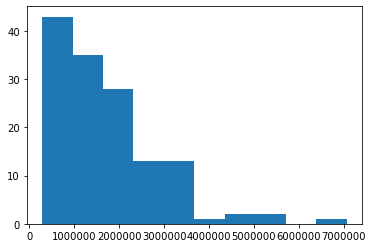

In [93]:
plt.hist(waterfront.price);

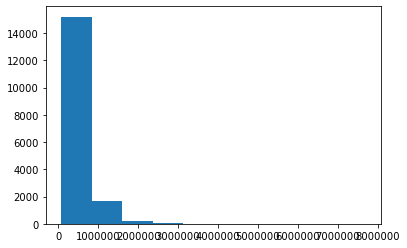

In [94]:
plt.hist(no_waterfront.price);

In [95]:
# perform welch's t-test (two-tailed by default)
welch = scipy.stats.ttest_ind(waterfront.price, no_waterfront.price, equal_var=False)
print('p-value:',welch[1]/2)

p-value: 3.470220628045268e-23


### P-value is 3.47e-23, which is lower than 0.05 alpha, indicating we can reject the null hypothesis in favor of the alternative, that houses on a waterfront sell for more on average than houses not on a waterfront.

## Zipcode Dummy Variables

In [96]:
# Create dummy variables for zip code 
zip_dummies = pd.get_dummies(df['zipcode'].astype(str), dtype=int, drop_first=True)
df.drop(columns=['zipcode'],inplace=True)
new_cols = 'zip'+zip_dummies.columns
zip_dummies.columns = new_cols
zip_dummies.head()

,zip98002,zip98003,zip98004,zip98005,zip98006,zip98007,zip98008,zip98010,zip98011,zip98014,...,zip98146,zip98148,zip98155,zip98166,zip98168,zip98177,zip98178,zip98188,zip98198,zip98199
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Stats Test 2: Zip Code vs. Price
### ANOVA Test
**Rationale:** Comparing means of several independent samples<br>
**Ho:** There is no difference in the average price of houses in different zip codes.<br>
**Ha:** Houses in different zip codes have different average house prices.

In [97]:
# Concatenate zipcode dummy variables with with main dataframe
X_dummies = pd.concat([df['price'], zip_dummies], axis=1)
formula = "price ~ "+ '+'.join(list(zip_dummies.columns))
model = ols(formula, X_dummies).fit()
table = sm.stats.anova_lm(model, typ=2)
table.sort_values('PR(>F)').head(10)

,sum_sq,df,F,PR(>F)
zip98039,1.349927e+14,1.0,1611.813889,0.000000e+00
zip98004,1.605789e+14,1.0,1917.312755,0.000000e+00
zip98040,1.029211e+14,1.0,1228.878990,4.127097e-260
zip98112,8.604568e+13,1.0,1027.385948,5.199502e-219
zip98006,5.262880e+13,1.0,628.388162,3.075398e-136
zip98033,4.278113e+13,1.0,510.806899,1.763268e-111
zip98075,3.735075e+13,1.0,445.968136,9.416298e-98
zip98105,3.661641e+13,1.0,437.200116,6.829872e-96
zip98199,3.504893e+13,1.0,418.484416,6.444296e-92
zip98119,3.393523e+13,1.0,405.186836,4.325909e-89


### _____________interpretation here ___________

## Stats Test 3: ___ vs ___
### ____ Test
**Rationale:** Comparing means of several independent samples<br>
**Ho:** There is no difference in the average price of houses in different zip codes.<br>
**Ha:** Houses in different zip codes have different average house prices.

# Step 4: Feature Engineering

After doing this, you will want to go back to steps 2 and 3 to investigate these new features.
- **Feature Engineering**: You must create at least 3 new features to test in your model. Those features do not have to make it into your final model, as they might be removed during the feature selection process. That is expected, but you still need to explain the features you engineer and your thought process behind why you thought they would explain the selling price of the house.

## House Years Old 

In [98]:
# Create yrs_old column
yrs_old = df['yr_sold']- df['yr_built']

## Distance from City 
Distance (miles) from each house to Pikes Place Market (essentially downtown seattle)

In [99]:
distances=[]
for (lat, long) in list(zip(df['lat'],df["long"])):
    p1 = Point(f'{lat} {long}')
    pikes_place = Point("47.6086 -122.3401")
    distances.append(distance.distance(p1,pikes_place).miles)

Add new features to a dataframe, run model

In [150]:
# add new features to dataframe, concat with main dataframe
new_features = pd.DataFrame()
new_features['yrs_old'] = yrs_old
new_features['miles_from_city'] = distances

#### Run model with new features and zipcode dummies included

In [151]:
y = df[['price']]
X_feat = pd.concat([df.iloc[:,1:], new_features, zip_dummies], axis=1)
lr = LinearRegression()
lr.fit(X_feat,y)
lr.score(X_feat,y)

0.8137060573904992

## Interaction Features

Get R-squared for interactions between every possible feature combination

In [152]:
# Generate combinations of features
interactions = list(combinations(X.columns, 2))
interaction_dict = {}

for interaction in interactions:
    X_copy = X.copy()
    X_copy['interact'] = X_copy[interaction[0]] * X_copy[interaction[1]]  
    model = LinearRegression() #run model with each possible interaction
    model.fit(X_copy, y)
    interaction_dict[model.score(X_copy, y)] = interaction # add R-squared for each interaction to a dictionary
sorted(interaction_dict.items(), reverse = True)[:5]

[(0.7457347787266437, ('sqft_living', 'grade')),
 (0.7382650113991491, ('bathrooms', 'grade')),
 (0.7354181402975495, ('sqft_living', 'sqft_above')),
 (0.7345638908027445, ('bathrooms', 'sqft_living')),
 (0.7339813880306623, ('grade', 'sqft_above'))]

Add best 20 interactions to model

In [153]:
interaction_df = X.copy()
top_interactions = sorted(interaction_dict.keys(), reverse = True)[:20]

for interaction in top_interactions:
    feature1 = interaction_dict[interaction][0]
    feature2 = interaction_dict[interaction][1]
    interaction_df[feature1+'_X_'+feature2] = interaction_df[feature1] * interaction_df[feature2]
    new_features[feature1+'_X_'+feature2] = interaction_df[feature1] * interaction_df[feature2] #also add to new_features df
    model = LinearRegression() # run model with each added interaction term
    model.fit(interaction_df, y)
    r_squared = model.score(interaction_df, y)
    print('R-Squared is',r_squared,'after adding:  ',feature1+'_X_'+feature2)

R-Squared is 0.7457347787266437 after adding:   sqft_living_X_grade
R-Squared is 0.7462331641505675 after adding:   bathrooms_X_grade
R-Squared is 0.7463174156671007 after adding:   sqft_living_X_sqft_above
R-Squared is 0.746395951798805 after adding:   bathrooms_X_sqft_living
R-Squared is 0.7482497912462022 after adding:   grade_X_sqft_above
R-Squared is 0.7484432198610604 after adding:   bathrooms_X_sqft_above
R-Squared is 0.748532666640833 after adding:   grade_X_sqft_basement
R-Squared is 0.7492420212691102 after adding:   sqft_living_X_sqft_living15
R-Squared is 0.7494204522362912 after adding:   sqft_above_X_sqft_basement
R-Squared is 0.759631487354932 after adding:   sqft_living_X_waterfront
R-Squared is 0.7596363948206328 after adding:   sqft_living_X_view
R-Squared is 0.7600730814587703 after adding:   view_X_grade
R-Squared is 0.7601587808985887 after adding:   waterfront_X_sqft_above
R-Squared is 0.7603815617718462 after adding:   bathrooms_X_sqft_living15
R-Squared is 0.761

## Log Transformations

In [154]:
# generate new features for logs of non-normal features (based on histograms)
non_normal = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement','sqft_living15', 'sqft_lot15']
for feat in non_normal:
    new_features['log_'+feat] = df[feat].map(lambda x: np.log(x))
new_features = new_features.replace([np.inf, -np.inf], 0)
new_features.head()

,yrs_old,miles_from_city,sqft_living_X_grade,bathrooms_X_grade,sqft_living_X_sqft_above,bathrooms_X_sqft_living,grade_X_sqft_above,bathrooms_X_sqft_above,grade_X_sqft_basement,sqft_living_X_sqft_living15,...,log_bathrooms,log_sqft_living,log_sqft_lot,log_floors,log_condition,log_grade,log_sqft_above,log_sqft_basement,log_sqft_living15,log_sqft_lot15
0,28,14.389780,16560.0,18.0,4284900.0,4657.5,16560.0,4657.5,0.0,4947300.0,...,0.810930,7.635304,9.093020,0.693147,1.386294,2.079442,7.635304,0.000000,7.779049,8.948976
1,37,5.465502,23200.0,24.0,5307000.0,8700.0,14640.0,5490.0,8560.0,6873000.0,...,1.098612,7.972466,8.814330,0.000000,1.609438,2.079442,7.512071,6.975414,7.770645,8.745603
2,17,10.324296,41470.0,27.5,14212900.0,9425.0,41470.0,9425.0,0.0,13986700.0,...,0.916291,8.234830,9.295876,0.693147,1.098612,2.397895,8.234830,0.000000,8.218787,9.178334
3,25,8.174302,54720.0,42.0,20793600.0,15960.0,54720.0,15960.0,0.0,18468000.0,...,1.252763,8.425078,9.589325,0.693147,1.098612,2.484907,8.425078,0.000000,8.306472,9.562827
4,10,12.615314,22950.0,22.5,6502500.0,6375.0,22950.0,6375.0,0.0,5737500.0,...,0.916291,7.843849,8.589700,0.693147,1.098612,2.197225,7.843849,0.000000,7.718685,8.306472


#### Run model with new features, interactions, log transformations, and dummy variables included

In [155]:
y = df[['price']]
X_logs = pd.concat([df.iloc[:,1:], new_features, zip_dummies], axis=1)

# run model with log features included
lr = LinearRegression()
lr.fit(X_logs,y)
lr.score(X_logs,y)

0.860602408944267

## Polynomial Features¶

In [171]:
non_normal = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_living15', 'sqft_lot15']
for feat in non_normal:
    new_features[feat+'^2'] = df[feat]**2
    new_features[feat+'^3'] = df[feat]**3
new_features.head()

,yrs_old,miles_from_city,sqft_living_X_grade,bathrooms_X_grade,sqft_living_X_sqft_above,bathrooms_X_sqft_living,grade_X_sqft_above,bathrooms_X_sqft_above,grade_X_sqft_basement,sqft_living_X_sqft_living15,...,condition^2,condition^3,grade^2,grade^3,sqft_above^2,sqft_above^3,sqft_living15^2,sqft_living15^3,sqft_lot15^2,sqft_lot15^3
0,28,14.389780,16560.0,18.0,4284900.0,4657.5,16560.0,4657.5,0.0,4947300.0,...,16,64,64,512,4284900.0,8.869743e+09,5712100.0,1.365192e+10,59290000.0,4.565330e+11
1,37,5.465502,23200.0,24.0,5307000.0,8700.0,14640.0,5490.0,8560.0,6873000.0,...,25,125,64,512,3348900.0,6.128487e+09,5616900.0,1.331205e+10,39476089.0,2.480283e+11
2,17,10.324296,41470.0,27.5,14212900.0,9425.0,41470.0,9425.0,0.0,13986700.0,...,9,27,121,1331,14212900.0,5.358263e+10,13764100.0,5.106481e+10,93799225.0,9.084455e+11
3,25,8.174302,54720.0,42.0,20793600.0,15960.0,54720.0,15960.0,0.0,18468000.0,...,9,27,144,1728,20793600.0,9.481882e+10,16402500.0,6.643012e+10,202379076.0,2.879045e+12
4,10,12.615314,22950.0,22.5,6502500.0,6375.0,22950.0,6375.0,0.0,5737500.0,...,9,27,81,729,6502500.0,1.658138e+10,5062500.0,1.139062e+10,16402500.0,6.643012e+10


#### Run model with new features, interactions, log transformations, polynomials, and dummy variables

In [172]:
y = df[['price']]
X_poly = pd.concat([df.iloc[:,1:], new_features, zip_dummies], axis=1)

# run model with log features included
lr = LinearRegression()
lr.fit(X_poly,y)
lr.score(X_poly,y)

0.7668235427278097

# Step 5: Train-Test Split 


### 5.1) Perform a train-test split of the data.

In [173]:
X_all = pd.concat([df.iloc[:,1:], zip_dummies, new_features], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)
X_all.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,condition^2,condition^3,grade^2,grade^3,sqft_above^2,sqft_above^3,sqft_living15^2,sqft_living15^3,sqft_lot15^2,sqft_lot15^3
0,4.0,2.25,2070.0,8893.0,2.0,0,0,4,8,2070.0,...,16,64,64,512,4284900.0,8.869743e+09,5712100.0,1.365192e+10,59290000.0,4.565330e+11
1,5.0,3.00,2900.0,6730.0,1.0,0,0,5,8,1830.0,...,25,125,64,512,3348900.0,6.128487e+09,5616900.0,1.331205e+10,39476089.0,2.480283e+11
2,4.0,2.50,3770.0,10893.0,2.0,0,2,3,11,3770.0,...,9,27,121,1331,14212900.0,5.358263e+10,13764100.0,5.106481e+10,93799225.0,9.084455e+11
3,3.0,3.50,4560.0,14608.0,2.0,0,2,3,12,4560.0,...,9,27,144,1728,20793600.0,9.481882e+10,16402500.0,6.643012e+10,202379076.0,2.879045e+12
4,3.0,2.50,2550.0,5376.0,2.0,0,0,3,9,2550.0,...,9,27,81,729,6502500.0,1.658138e+10,5062500.0,1.139062e+10,16402500.0,6.643012e+10


### 5.2) Fit your scaler to training the data.

### 5.3) Transform the testing set with the scaler.

### 5.4) Fit the model to the training data.

In [174]:
model_1 = LinearRegression()
model_1.fit(X_train, y_train)
print(model_1.score(X_train, y_train))
print(model_1.score(X_test, y_test))

0.7577490333246188
0.7527453572535668


### 5.5) Use the model to predict on the training set and the test set.

In [175]:
y_train_pred = model_1.predict(X_train)
y_test_pred = model_1.predict(X_test)

### Check normality of residuals

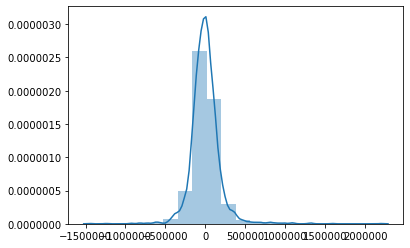

In [176]:
residuals = (y_test- y_test_pred)
sns.distplot(residuals, bins=20);

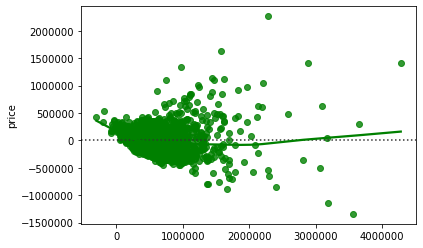

In [177]:
sns.residplot(y_test_pred, y_test, lowess=True, color="g")

### 5.6) Evaluate the training and test predictions using RMSE.

In [178]:
# RMSE of training and test set
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))
print(np.sqrt(mean_squared_error(y_test, y_test_pred)))

184762.50091725308
181380.53426119447


## Step 6: Feature Selection
- **Feature Selection** - There are many ways to do feature selection: filter methods, P-values, or recursive feature elimination (RFE). You should try multiple different techniques and combinations of them. For your final model, you will settle on a process of feature selection; this process should be clearly shown in your final notebook.


## Method 1: Remove Multicollinear Features
### Heatmap to vizualize multicollinearity

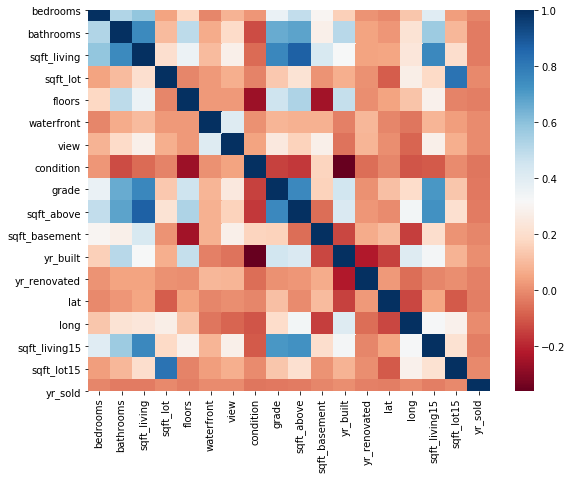

In [179]:
plt.figure(figsize=[9,7]);
sns.heatmap(df.iloc[:,1:].corr(), cmap='RdBu');

### Use stacking to look at feature pairs with highest correlations

In [180]:
corr=df.iloc[:,1:].corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr['pairs'] = list(zip(corr.level_0, corr.level_1))
corr.drop(columns=['level_1', 'level_0'], inplace = True)
corr.columns = ['correlation', 'pairs']
corr.drop_duplicates(inplace=True)
corr[(corr.correlation >0.75) & (corr.correlation <1.0)]

,correlation,pairs
164,0.876159,"(sqft_above, sqft_living)"
45,0.876159,"(sqft_living, sqft_above)"
70,0.824427,"(sqft_lot, sqft_lot15)"
291,0.824427,"(sqft_lot15, sqft_lot)"
44,0.765792,"(sqft_living, grade)"
146,0.765792,"(grade, sqft_living)"
153,0.759399,"(grade, sqft_above)"
170,0.759399,"(sqft_above, grade)"
272,0.758828,"(sqft_living15, sqft_living)"
51,0.758828,"(sqft_living, sqft_living15)"


### Retain features with Variance Inflation Factors under 10

In [181]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif_features = vif[vif['VIF Factor'] <10]['features']
vif[vif['VIF Factor'] <10].head()

,VIF Factor,features
4,8.579093,floors
5,6.341989,waterfront
6,8.728689,view
12,1.157804,yr_renovated
13,1.646664,lat


In [182]:
# Observe model performance using only features with low VIF
model_2 = LinearRegression()
model_2.fit(X_train[vif_features], y_train)
print(model_2.score(X_train[vif_features],y_train))      
print(model_2.score(X_test[vif_features],y_test))     
# not going to bother looking at RMSE

0.5815848505200002
0.6054285911290826


## Method 2: K-Best Feature Selection

In [183]:
# determine optimal k with a loop
for k in range(80,120):
    selector = SelectKBest(f_regression, k=k)
    selector.fit(X_train, y_train)
    kbest_features = X_train.columns[selector.get_support()]

    model_3 = LinearRegression()
    model_3.fit(X_train[kbest_features], y_train)
    print(k, model_3.score(X_train[kbest_features],y_train))

80 0.8320366516576683
81 0.8323217791662135
82 0.8330990808199319
83 0.8332475797695079
84 0.8350824510199438
85 0.8358607342453481
86 0.8368847124566763
87 0.8375101818808528
88 0.8376589924946596
89 0.8385532538985871
90 0.8385618221075308
91 0.838623255040355
92 0.840767567820514
93 0.8418508612796707
94 0.8423396467677586
95 0.8432250504041954
96 0.8436647506446147
97 0.8447410907562085
98 0.8451475747588456
99 0.84778580441275
100 0.758478579415037
101 0.759206322555764
102 0.7650159401788088
103 0.7603662354700539
104 0.7590798584407238
105 0.7540813540594962
106 0.7606100530303572
107 0.7565271420919057
108 0.7561834243509973
109 0.758968044325961
110 0.7673348757943628
111 0.7540449067381603
112 0.7543340502072857
113 0.7538651271723187
114 0.7541709140212327
115 0.7619289943065715
116 0.7550271257977491
117 0.7589926227663862
118 0.7539640476081262
119 0.7543050713643442


In [184]:
# run model with best 99 features
selector = SelectKBest(f_regression, k=99)
selector.fit(X_train, y_train)
kbest_features = X_train.columns[selector.get_support()]

model_3 = LinearRegression()
model_3.fit(X_train[kbest_features], y_train)
print(model_3.score(X_train[kbest_features],y_train))
print(model_3.score(X_test[kbest_features],y_test))

0.84778580441275
0.8479639152257518


In [185]:
# observe RMSE
y_train_pred = model_3.predict(X_train[kbest_features])
y_test_pred = model_3.predict(X_test[kbest_features])

print(np.sqrt(mean_squared_error(y_train, y_train_pred)))
print(np.sqrt(mean_squared_error(y_test, y_test_pred)))

146456.5000102698
142230.1892067965


## Method 3: Recursive Feature Selection

## Step 7: Evaluate your different models in order to determine the best model overall.
- Model Interpretation: One of the benefits of a linear regression model is that you can interpret the coefficients of the model to derive insights. For example, which feature has the biggest impact on the price of the house? Was there a feature that you thought would be significant but was not? Think if you were a real estate agent helping clients price their house: what information would you find most helpful from this model?

## Step 8:  Refit your best model to the entire dataset.

## Step 9: Save your final model using pickle.

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/